In [1]:
# !pip uninstall tensorflow opencv-python opencv-contrib-python mediapipe numpy -y

Found existing installation: opencv-contrib-python 4.8.1.78
Uninstalling opencv-contrib-python-4.8.1.78:
  Successfully uninstalled opencv-contrib-python-4.8.1.78
Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


You can safely remove it manually.
You can safely remove it manually.


# Dependencies and imports

In [1]:
!pip install numpy==1.26.4
!pip install opencv-contrib-python==4.8.1.78
!pip install mediapipe 
!pip install tensorflow scikit-learn matplotlib

  Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.32.0
    Uninstalling protobuf-6.32.0:
      Successfully uninstalled protobuf-6.32.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires rich<14,>=10.14.0, but you have rich 14.1.0 which is incompatible.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 4.25.8 which is incompatible.


  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl (435 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 6.32.0 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.0 which is incompatible.
streamlit 1.37.1 requires rich<14,>=10.14.0, but you have rich 14.1.0 which is incompatible.


In [67]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import datetime
import mediapipe as mp
import tensorflow as tf
from time import sleep
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [4]:
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("MediaPipe:", mp.__version__)
print("TensorFlow:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

NumPy: 1.26.4
OpenCV: 4.8.1
MediaPipe: 0.10.21
TensorFlow: 2.20.0
GPUs available: []


# MediaPipe Holistic for keypoints extraction

In [7]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [9]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [11]:
face_style = mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=1, circle_radius=1)
face_points = mp_drawing.DrawingSpec(color=(0, 128, 255), thickness=1, circle_radius=1)

pose_style = mp_drawing.DrawingSpec(color=(255, 128, 0), thickness=2, circle_radius=4)
pose_points = mp_drawing.DrawingSpec(color=(255, 200, 100), thickness=1, circle_radius=2)

left_hand_style = mp_drawing.DrawingSpec(color=(147, 112, 219), thickness=2, circle_radius=4)
left_hand_points = mp_drawing.DrawingSpec(color=(186, 85, 211), thickness=1, circle_radius=2)

right_hand_style = mp_drawing.DrawingSpec(color=(60, 179, 113), thickness=2, circle_radius=4)
right_hand_points = mp_drawing.DrawingSpec(color=(144, 238, 144), thickness=1, circle_radius=2)

In [13]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, face_style, face_points)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, pose_style, pose_points) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, left_hand_style, left_hand_points)   
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, right_hand_style, right_hand_points) 

In [15]:
cap = cv2.VideoCapture(0)
 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        
        draw_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [17]:
# l/r hand -> 21 (x,y,z), pose -> 33 (x,y,z,visibility), face -> 468 (x,y,z)
len(results.face_landmarks.landmark)

468

In [19]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [21]:
result_test = extract_keypoints(results)
len(result_test)

1662

# Data collection

In [31]:
DATA_PATH = os.path.join('MSL_Data') 
actions = np.array(['А', 'Б', 'В', 'Г', 'Д', 'Ѓ', 'Е', 'Ж', 'З', 'Ѕ', 'И', 'Ј', 'К', 'Л', 'Љ', 'М', 'Н', 'Њ',
                   'О', 'П', 'Р', 'С', 'Т', 'Ќ', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Џ', 'Ш'])
action_labels = np.array(['A', 'B', 'V', 'G', 'D', 'Gj', 'E', 'Zh', 'Z', 'Dz', 'I', 'J', 'K', 'L', 'Lj', 'M', 'N', 'Nj',
                   'O', 'P', 'R', 'S', 'T', 'Kj', 'U', 'F', 'H', 'C', 'Ch', 'Dj', 'Sh'])
num_videos = 10
num_frames = 30
start_folder = 31

In [29]:
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    
    os.makedirs(action_path, exist_ok=True)

    existing_dirs = [d for d in os.listdir(action_path) if d.isdigit()]
    if existing_dirs:
        dirmax = np.max(np.array(existing_dirs).astype(int))
    else:
        dirmax = 0

    for sequence in range(1, num_videos + 1):
        new_dir = os.path.join(action_path, str(dirmax + sequence))
        os.makedirs(new_dir, exist_ok=True)

In [33]:
data_collection_map = {label:start_folder for label in actions}
data_collection_map

In [27]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    current_action_index = 0
    recording = False
    frame_num = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue

        image, results = mediapipe_detection(frame, holistic)
        draw_landmarks(image, results)

        action = actions[current_action_index]
        action_label = action_labels[current_action_index]
        sequence = data_collection_map[action]

        if not recording:
            cv2.putText(image, f"Press 's' to record {action_label} (Video #{sequence})", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        else:
            cv2.putText(image, f"Recording {action_label} - Frame {frame_num+1}/30", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.imshow('OpenCV Feed', image)

        key = cv2.waitKey(10) & 0xFF

        if key == ord('q'):
            break

        elif key == ord('s') and not recording:
            recording = True
            frame_num = 0
            print(f"Recording action: {action}, Video #{sequence}")
            sleep(1)

        elif key == ord('n') and not recording:
            current_action_index = (current_action_index + 1) % len(actions)
            print(f"Switched to action: {actions[current_action_index]}")

        if recording:
            keypoints = extract_keypoints(results)

            save_dir = os.path.join(DATA_PATH, action, str(sequence))
            os.makedirs(save_dir, exist_ok=True)
            np.save(os.path.join(save_dir, str(frame_num)), keypoints)

            frame_num += 1
            cv2.waitKey(30)

            if frame_num >= num_frames:
                print(f"Finished recording: {action}, Video #{sequence}")
                data_collection_map[action] += 1
                recording = False

cap.release()
cv2.destroyAllWindows()

Switched to action: Б
Switched to action: В
Switched to action: Г
Switched to action: Д
Switched to action: Ѓ
Switched to action: Е
Switched to action: Ж
Switched to action: З
Switched to action: Ѕ
Switched to action: И
Switched to action: Ј
Switched to action: К
Switched to action: Л
Switched to action: Љ
Switched to action: М
Switched to action: Н
Switched to action: Њ
Switched to action: О
Switched to action: П
Switched to action: Р
Switched to action: С
Switched to action: Т
Switched to action: Ќ
Switched to action: У
Recording action: У, Video #11
Finished recording: У, Video #11
Recording action: У, Video #12
Finished recording: У, Video #12
Recording action: У, Video #13
Finished recording: У, Video #13
Recording action: У, Video #14
Finished recording: У, Video #14
Recording action: У, Video #15
Finished recording: У, Video #15
Recording action: У, Video #16
Finished recording: У, Video #16
Recording action: У, Video #17
Finished recording: У, Video #17
Recording action: У, Vid

In [35]:
data_collection_map

{'А': 31,
 'Б': 31,
 'В': 31,
 'Г': 31,
 'Д': 31,
 'Ѓ': 31,
 'Е': 31,
 'Ж': 31,
 'З': 31,
 'Ѕ': 31,
 'И': 31,
 'Ј': 31,
 'К': 31,
 'Л': 31,
 'Љ': 31,
 'М': 31,
 'Н': 31,
 'Њ': 31,
 'О': 31,
 'П': 31,
 'Р': 31,
 'С': 31,
 'Т': 31,
 'Ќ': 31,
 'У': 31,
 'Ф': 31,
 'Х': 31,
 'Ц': 31,
 'Ч': 31,
 'Џ': 31,
 'Ш': 31}

In [37]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'А': 0,
 'Б': 1,
 'В': 2,
 'Г': 3,
 'Д': 4,
 'Ѓ': 5,
 'Е': 6,
 'Ж': 7,
 'З': 8,
 'Ѕ': 9,
 'И': 10,
 'Ј': 11,
 'К': 12,
 'Л': 13,
 'Љ': 14,
 'М': 15,
 'Н': 16,
 'Њ': 17,
 'О': 18,
 'П': 19,
 'Р': 20,
 'С': 21,
 'Т': 22,
 'Ќ': 23,
 'У': 24,
 'Ф': 25,
 'Х': 26,
 'Ц': 27,
 'Ч': 28,
 'Џ': 29,
 'Ш': 30}

In [41]:
sequences, labels = [], []
for action in actions:
    print(f"Start sequence merge for '{action}'")
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int): 
        window = []
        try:
            for frame_num in range(num_frames):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
        except Exception as e:
            print(f"Skipping sequence {sequence} in action '{action}' due to error: {e}")

Start sequence merge for 'А'
Start sequence merge for 'Б'
Start sequence merge for 'В'
Start sequence merge for 'Г'
Start sequence merge for 'Д'
Start sequence merge for 'Ѓ'
Start sequence merge for 'Е'
Start sequence merge for 'Ж'
Start sequence merge for 'З'
Start sequence merge for 'Ѕ'
Start sequence merge for 'И'
Start sequence merge for 'Ј'
Start sequence merge for 'К'
Start sequence merge for 'Л'
Start sequence merge for 'Љ'
Start sequence merge for 'М'
Start sequence merge for 'Н'
Start sequence merge for 'Њ'
Start sequence merge for 'О'
Start sequence merge for 'П'
Start sequence merge for 'Р'
Start sequence merge for 'С'
Start sequence merge for 'Т'
Start sequence merge for 'Ќ'
Start sequence merge for 'У'
Start sequence merge for 'Ф'
Start sequence merge for 'Х'
Start sequence merge for 'Ц'
Start sequence merge for 'Ч'
Start sequence merge for 'Џ'
Start sequence merge for 'Ш'


In [43]:
x = np.array(sequences)
x.shape

(930, 30, 1662)

In [45]:
y = to_categorical(labels).astype(int)
y.shape

(930, 31)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [49]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((837, 30, 1662), (93, 30, 1662), (837, 31), (93, 31))

# Define and train model

In [51]:
base_dir = os.path.expanduser("~")
log_dir = os.path.join(base_dir, "Desktop", "Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [85]:
model = Sequential()
model.add(Input(shape=(30, 1662)))
# model.add(LSTM(64, return_sequences=True, activation='relu'))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [87]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 31)             │         1,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,375 (1.71 MB)

 Trainable params: 449,375 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [91]:
start_time = time.time()
history = model.fit(x_train, y_train, epochs=200, callbacks=[tb_callback])
end_time = time.time()

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.0346 - loss: 3.4410
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.0478 - loss: 3.3936
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.0753 - loss: 3.3361
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.0729 - loss: 3.2875
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - categorical_accuracy: 0.0956 - loss: 3.2237
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.1075 - loss: 3.2161
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.1123 - loss: 3.1955
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.1207 - loss: 3.1259
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.1266 - loss: 3.0863
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.1422 - loss: 2.9819
Epoch 11/200
27/27 

In [93]:
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Training time: {minutes} min {seconds} sec")

Training time: 1 min 33 sec


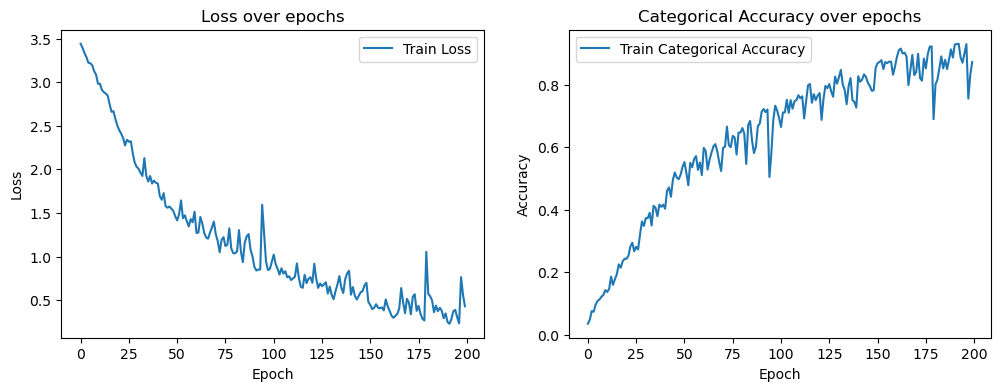

In [95]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Categorical Accuracy')
if 'val_categorical_accuracy' in history.history:
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Categorical Accuracy')
plt.title('Categorical Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()